<a href="https://colab.research.google.com/github/cusiandrea/datascienceportfolio/blob/main/Sentiment_Analysis_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment analysis exercise

The goal is to build a classification model in order to classify a movie review as positive or negative.
The classification is also performed wiht a pre-trained Spacy model.

In [157]:
import pandas as pd
import numpy as np

##The dataset

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A portion of IMDB reviews dataset is loaded

In [159]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/datasets/Sentiment_Analysis/SMALL_IMDB.csv')

In [160]:
dataset.head()

,review,sentiment
0,If there were two parts that the physically to...,positive
1,"As a reviewer has already commented, this made...",positive
2,Gday Mates! just watched Croc Hunter the movie...,negative
3,I will admit that I'm only a college student a...,negative
4,This is possibly the worst film I have ever se...,negative


In [161]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


The dataset has 10.000 samples and 2 columns (the review and its sentiment)

In [162]:
dataset.isna().sum()

,0
review,0
sentiment,0


In [163]:
dataset.duplicated().sum()

17

In [164]:
dataset.drop_duplicates(inplace=True)

The dataset does not have missing data and has only 17 duplicated samples, which are removed

<ipython-input-165-772e50d3ddcb>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(['positive', 'negative'], [dataset['sentiment'].value_counts()[0], dataset['sentiment'].value_counts()[1]], color=colors)
<ipython-input-165-772e50d3ddcb>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(['positive', 'negative'], [dataset['sentiment'].value_counts()[0], dataset['sentiment'].value_counts()[1]], color=colors)


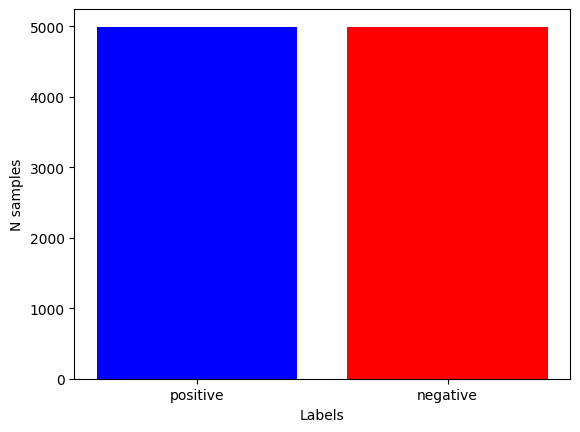

In [165]:
import matplotlib.pyplot as plt
colors = ['blue', 'red']
plt.bar(['positive', 'negative'], [dataset['sentiment'].value_counts()[0], dataset['sentiment'].value_counts()[1]], color=colors)
plt.xlabel('Labels')
plt.ylabel('N samples')
plt.show()

The two sentiment classes (positive and negative) are well balanced in the dataset.

These labels are converted in a numeric format

In [166]:
label_mapping = {'positive': 1, 'negative': 0}
dataset['sentiment'] = dataset['sentiment'].map(label_mapping)
dataset.head()

,review,sentiment
0,If there were two parts that the physically to...,1
1,"As a reviewer has already commented, this made...",1
2,Gday Mates! just watched Croc Hunter the movie...,0
3,I will admit that I'm only a college student a...,0
4,This is possibly the worst film I have ever se...,0


##Naive Bayes Model

A text cleaning function is defined, in order to keep only the meaningful content of the reviews.

In particular:
* words are put in lowercase
* punctuation is removed
* words are lemmatized
* stopwords are removed
* numbers are removed
* Spacy library is imported and an english language model is loaded

In [167]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import spacy
import re

english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Every review is cleaned and saved in a list called *reviews_cleaned*

In [169]:
reviews = dataset['review']

reviews_cleaned = []
for r in reviews:
    reviews_cleaned.append(data_cleaner(r))

Let's compare a review and its cleaned version

In [170]:
dataset['review'][0]

"If there were two parts that the physically towering, ugly-charismatic actor Gérard Depardieu was born, as a Frenchman, to play, it must surely have been Cyrano de Bergerac and the orator Georges Danton. Here he dominates the film both through the breadth of his shoulders and the power of his voice; his charisma carries the part despite the fact that it is made clear that the character has as much blood on his hands as any of the rest of them. Danton feasts while the people of Paris starve... but he is the one man who can challenge the tyranny imposed by the dreaded Committee of Public Safety in the name of 'freedom', and he is presented as the hero of the film -- despite the fact that the source play practically idolises his opponent Robespierre!<br /><br />For those who know the characters from history, there is interest to be had in identifying the minor parts: the frog-faced Tallien, Couthon the cripple, Fouquier-Tinville the tribunal's prosecutor, the dashing fop St-Just, the epi

In [171]:
reviews_cleaned[0]

'two part physically tower ugly charismatic actor gérard depardieu bear frenchman play must surely cyrano de bergerac orator george danton dominate film breadth shoulder power voice charisma carry part despite fact make clear character much blood hand rest danton feast people paris starve one man challenge tyranny impose dread committee public safety name freedom present hero film despite fact source play practically idolise opponent robespierre br br know character history interest identify minor part frog face tallien couthon cripple fouqui tinville tribunal prosecutor dash fop st epic painter david script cut little slack respect name often late come minor character identify hollywood style info dump make sure audience place event historical context film take grant know go happen sometimes take much grant rely close knowledge date provide sting tail fact robespierre follow danton shortly scaffold br br consider film entirely satisfactory ebb away towards end structure story lead gre

The cleaned dataset is split in train and test set

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_cleaned, dataset['sentiment'], test_size=0.2, random_state=0)

In order to be read by the model, text needs to be vectorized

In [173]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_train_vectorized = vec.fit_transform(X_train).toarray()
X_test_vectorized = vec.transform(X_test).toarray()

A Multinomial Naive Bayes classification model is defined.

The performance on the test set is quite good (83%)

In [174]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()
NB_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [175]:
NB_model.score(X_train_vectorized, y_train)

0.9286250939143501

In [176]:
NB_model.score(X_test_vectorized, y_test)

0.8337506259389084

The following function returns the sentiment prediction (along with its probabilities) of a given review

In [178]:
def NB_prediction(sentence):
  """
  Returns the sentiment prediction (along with its probabilities) of a given review
  """
  sentence_vectorized = vec.transform([data_cleaner(sentence)])
  print('Probability negative: ', np.round(NB_model.predict_proba(sentence_vectorized)[0][0],2))
  print('Probability positive: ', np.round(NB_model.predict_proba(sentence_vectorized)[0][1],2))
  if NB_model.predict(sentence_vectorized)[0] == 0:
    print('Predicted negative')
  else:
    print('Predicted positive')
  return

Some examples:

In [180]:
NB_prediction('Awesome movie, I loved it')

Probability negative:  0.2
Probability positive:  0.8
Predicted positive


In [181]:
NB_prediction('Awesome music but awful photography')

Probability negative:  0.65
Probability positive:  0.35
Predicted negative


In [182]:
NB_prediction('It is a terrible movie')

Probability negative:  0.9
Probability positive:  0.1
Predicted negative


##Spacy pre-trained model

In [183]:
#!pip install spacytextblob

**Spacytextblob** is a pipeline component that enables sentiment analysis using the TextBlob library, which is imported and added to the Spacy model downloaded previously.

In [184]:
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')

Spacytextblob estimates sentiment with its *polarity* indicator.

For example:

In [185]:
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)

In [186]:
doc._.blob.polarity

-0.125

The following function returns 1 or 0 whether the Spacy polarity agrees with the real sentiment label.

In [189]:
def sentiment_checker(polarity, text, label, to_print=False):
  """
  Returns 1 or 0 whether the Spacy polarity agrees with the real sentiment label.
  If wanted, review, predicted label and real label are printed
  """
  if to_print:
    print(text)
    print('Real label: ', label)
    print('Spacy polarity: ', str(polarity))
    print('Naive Bayes model prediction: ', NB_model.predict(vec.transform([text]))[0])
    print('------------------------------------------------------------------')

  if (polarity > 0 and label == 1) or (polarity < 0 and label == 0):
    return 1
  else:
    return 0

The Spacy model predicts every review in the test set and the prediction is checked with the *sentiment_checker* function.

If prediction and label match, the variable *score_count* increases by 1.

*score_counts* lets us calculate the accuracy of the prediction, which is 70%.

In [190]:
score_count = 0
for r,s in zip(X_test,y_test):
    doc = nlp(r)
    score_count += sentiment_checker(doc._.blob.polarity,r,s)

In [191]:
score_count/len(y_test)

0.7035553329994992